This is code originally written by Francois Chollet (from our book). We will be manipulating it to serve our needs in style transfer.

You can download the original here: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb

We will also build from an implementation using the Tensorflow/Keras docs: https://www.tensorflow.org/tutorials/generative/style_transfer


___
# Neural style transfer Overview, Gatys's Method


This notebook contains the code samples found in Chapter 8, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----


Besides Deep Dream, another major development in deep learning-driven image modification that happened in the summer of 2015 is neural 
style transfer, introduced by Leon Gatys et al. The neural style transfer algorithm has undergone many refinements and spawned many 
variations since its original introduction, including a viral smartphone app, called Prisma. For simplicity, this section focuses on the 
formulation described in the original paper.

Neural style transfer consists in applying the "style" of a reference image to a target image, while conserving the "content" of the target 
image:



![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)


What is meant by "style" is essentially textures, colors, and visual patterns in the image, at various spatial scales, while the "content" 
is the higher-level macrostructure of the image. For instance, blue-and-yellow circular brush strokes are considered to be the "style" in 
the above example using Starry Night by Van Gogh, while the buildings in the Tuebingen photograph are considered to be the "content".

The idea of style transfer, tightly related to that of texture generation, has had a long history in the image processing community prior 
to the development of neural style transfer in 2015. However, as it turned out, the deep learning-based implementations of style transfer 
offered results unparalleled by what could be previously achieved with classical computer vision techniques, and triggered an amazing 
renaissance in creative applications of computer vision.

The key notion behind implementing style transfer is same idea that is central to all deep learning algorithms: we define a loss function 
to specify what we want to achieve, and we minimize this loss. We know what we want to achieve: conserve the "content" of the original image, 
while adopting the "style" of the reference image. If we were able to mathematically define content and style, then an appropriate loss 
function to minimize would be the following:

```
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
```


Where `distance` is a norm function such as the L2 norm, `content` is a function that takes an image and computes a representation of its 
"content", and `style` is a function that takes an image and computes a representation of its "style".

Minimizing this loss would cause `style(generated_image)` to be close to `style(reference_image)`, while `content(generated_image)` would 
be close to `content(generated_image)`, thus achieving style transfer as we defined it.

A fundamental observation made by Gatys et al. is that deep convolutional neural networks offer precisely a way to mathematically defined 
the `style` and `content` functions. Let's see how.

In [1]:
# workaround for multiple OpenMP on Mac
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf

import IPython.display as display
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title==None:
        title = str(image.shape)
    plt.title(title)

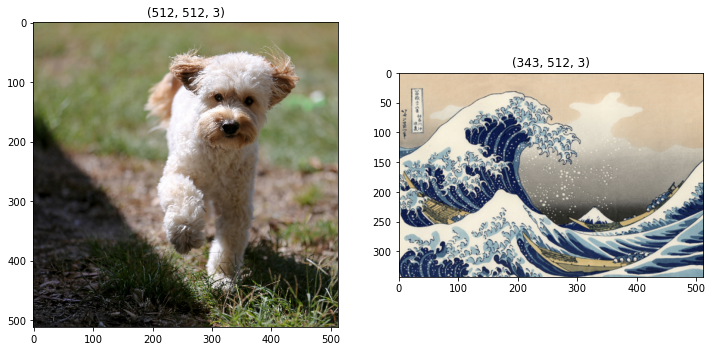

In [3]:
# This is the path to the image you want to transform.
content_path = 'images/dog.jpg'
# This is the path to the style image.
style_path = 'images/wave_style.png'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image)

plt.subplot(1, 2, 2)
imshow(style_image)

## The content loss


As you already know, activations from earlier layers in a network contain _local_ information about the image, while activations from 
higher layers contain increasingly _global_ and _abstract_ information. Formulated in a different way, the activations of the different 
layers of a convnet provide a decomposition of the contents of an image over different spatial scales. Therefore we expect the "content" of 
an image, which is more global and more abstract, to be captured by the representations of a top layer of a convnet.

A good candidate for a content loss would thus be to consider a pre-trained convnet, and define as our loss the L2 norm between the 
activations of a top layer computed over the target image and the activations of the same layer computed over the generated image. This 
would guarantee that, as seen from the top layer of the convnet, the generated image will "look similar" to the original target image. 
Assuming that what the top layers of a convnet see is really the "content" of their input images, then this does work as a way to preserve 
image content.

## The style loss


While the content loss only leverages a single higher-up layer, the style loss as defined in the Gatys et al. paper leverages multiple 
layers of a convnet: we aim at capturing the appearance of the style reference image at all spatial scales extracted by the convnet, not 
just any single scale.

For the style loss, the Gatys et al. paper leverages the "Gram matrix" of a layer's activations, i.e. the inner product between the feature maps 
of a given layer. This inner product can be understood as representing a map of the correlations between the features of a layer. These 
feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically corresponds to the appearance 
of the textures found at this scale.

Hence the style loss aims at preserving similar internal correlations within the activations of different layers, across the style 
reference image and the generated image. In turn, this guarantees that the textures found at different spatial scales will look similar 
across the style reference image and the generated image.

## In short


In short, we can use a pre-trained convnet to define a loss that will:

* Preserve content by maintaining similar high-level layer activations between the target content image and the generated image. The 
convnet should "see" both the target image and the generated image as "containing the same things".
* Preserve style by maintaining similar _correlations_ within activations for both low-level layers and high-level layers. Indeed, feature 
correlations capture _textures_: the generated and the style reference image should share the same textures at different spatial scales.

Now let's take a look at a Keras implementation of the original 2015 neural style transfer algorithm. As you will see, it shares a lot of 
similarities with the Deep Dream implementation we developed in the previous section.

## Neural style transfer in Keras


Neural style transfer can be implemented using any pre-trained convnet. Here we will use the VGG19 network, used by Gatys et al in their paper. 
VGG19 is a simple variant of the VGG16 network we introduced in Chapter 5, with three more convolutional layers.

This is our general process:

* Set up a network that will compute VGG19 layer activations for the style reference image, the target image, and the generated image at 
the same time.
* Use the layer activations computed over these three images to define the loss function described above, which we will minimize in order 
to achieve style transfer.
* Set up a gradient descent process to minimize this loss function.


Let's start by defining the paths to the two images we consider: the style reference image and the target image. To make sure that all 
images processed share similar sizes (widely different sizes would make style transfer more difficult), we will later resize them all to a 
shared height of 400px.


Let's define the content loss, meant to make sure that the top layer of the VGG19 convnet will have a similar view of the target image and 
the generated image. We will also define the style loss. It leverages an auxiliary function to compute the Gram matrix of an input matrix, i.e., a map of the covariances 
found in the original feature matrix.

To these two loss components, we add a third one, the "total variation loss". It is meant to encourage spatial continuity in the generated 
image, thus avoiding overly pixelated results. You could interpret it as a regularization loss.

The loss that we minimize is a weighted average of these three losses. To compute the content loss, we only leverage one top layer, the 
`block5_conv2` layer, while for the style loss we use a list of layers than spans both low-level and high-level layers. We add the total 
variation loss at the end.

Depending on the style reference image and content image you are using, you will likely want to tune the `content_weight` coefficient, the 
contribution of the content loss to the total loss. A higher `content_weight` means that the target content will be more recognizable in 
the generated image.


Finally, we set up the gradient descent process. In the original Gatys et al. paper, optimization is performed using the L-BFGS algorithm, 
but we will instead use the built in optmizer that is included in tensorflow. Specifically, we will use an AdaM optimizer.

In particular, we will use an implementation from the Tensorflow/Keras docs: https://www.tensorflow.org/tutorials/generative/style_transfer



Keep in mind that what this technique achieves is merely a form of image re-texturing, or texture transfer. It will work best with style 
reference images that are strongly textured and highly self-similar, and with content targets that don't require high levels of details in 
order to be recognizable. It would typically not be able to achieve fairly abstract feats such as "transferring the style of one portrait to 
another". The algorithm is closer to classical signal processing than to AI, so don't expect it to work like magic!

Additionally, do note that running this style transfer algorithm is quite slow. However, the transformation operated by our setup is simple 
enough that it can be learned by a small, fast feedforward convnet as well -- as long as you have appropriate training data available. Fast 
style transfer can thus be achieved by first spending a lot of compute cycles to generate input-output training examples for a fixed style 
reference image, using the above method, and then training a simple convnet to learn this style-specific transformation. Once that is done, 
stylizing a given image is instantaneous: it's a just a forward pass of this small convnet.


In [4]:
# we will use this layer in order to preserve content
# using VGG. The loss will be the squared difference in activations
content_layers = ['block5_conv2'] 

# We will use these earlier layers to help presevre style
# using VGG. The loos will be the difference in Grammians
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']


Now we can use the Keras model class to inherit from. This model will be used only to calculate the output convolutions from VGG that we need.

It will return a dictionary of the content layer outputs and the style layer outputs.

In [5]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        # load in VGG
        self.vgg =  self.vgg_layers(style_layers + content_layers)
        # save what layers to use for style and content
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)
        
        # save a little memory and compuation 
        self.vgg.trainable = False

    # this function is called when the model is given an input
    # or set of inputs, such as model(image)
    def call(self, inputs):
        "Expects float input in [0,1]"
        # expand the image dynamic range to go from 0-255
        inputs = inputs*255.0
        # pre process the way VGG expects and get outputs
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        
        # return the tensors for content and style
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        # transform these to get Grammian
        style_outputs = [self.gram_matrix(style_output)
                         for style_output in style_outputs]

        # now create abstract structure with the name and reference
        #  to each tensor that we will eventually need for the loss
        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}
    
    @staticmethod
    def vgg_layers(layer_names):
        """ Creates a vgg model that returns a list of intermediate output values."""
        # Load our model. Load pretrained VGG, trained on imagenet data
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False

        outputs = [vgg.get_layer(name).output for name in layer_names]

        model = tf.keras.Model([vgg.input], outputs)
        return model

    # there are a number of ways to compute this value
    # the einsum is an efficient means of performing this, though.
    # we collapse the outputs from the convolutional layer
    # where the outputs were: 
    # (b)atch, spatial (i,j), and channels (d or c) for each set of activations
    @staticmethod
    def gram_matrix(input_tensor):
        # perform the summation
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        # normalize the grammin by the number of ij values
        i,j = 1,2 
        input_shape = tf.shape(input_tensor)
        ij_size = tf.cast(input_shape[i]*input_shape[j], tf.float32)
        return result/(ij_size)

In [6]:
def calc_style_loss(style_outputs, style_targets, style_weight):
    # add up the squared difference in grammians 
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    # normalize by the number of layers and user defined weight
    num_style_layers = len(style_outputs.keys())
    style_loss *= style_weight / num_style_layers

    return style_loss

def calc_content_loss(content_outputs, content_targets, content_weight):
    # take squared difference in layers 
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    # normalize by number of layers and weight
    num_content_layers = len(content_outputs.keys())
    content_loss *= content_weight / num_content_layers
    return content_loss

def calc_total_variation_loss(image, total_variation_weight):
    # just use the built in TV calculation in tf
    return total_variation_weight*tf.image.total_variation(image)

In [7]:
# build the VGG model for calcualting the losses
extractor = StyleContentModel(style_layers, content_layers)

# save off the style and content targets from VGG
# make these constants to help with the computations 
style_targets = extractor(tf.constant(style_image))['style']
content_targets = extractor(tf.constant(content_image))['content']

# now setup an updatable variable, init to the content image
# in actuality, this could start as any image
image = tf.Variable(content_image)

# setup the image clipping and AdaM optimizer
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# weights from the user for each loss
style_weight=1e-2
content_weight=1e4
total_variation_weight=50

# now we can setup a function in tf
# that will be eagerly executed
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        # calculate the losses and keep track of gradients
        # for all of these calcualtions
        outputs = extractor(image)
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        
        loss = calc_style_loss(style_outputs, style_targets, style_weight)
        loss += calc_content_loss(content_outputs, content_targets, content_weight)
        loss += calc_total_variation_loss(image, total_variation_weight)

    # use tracked gradients to optimize image
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

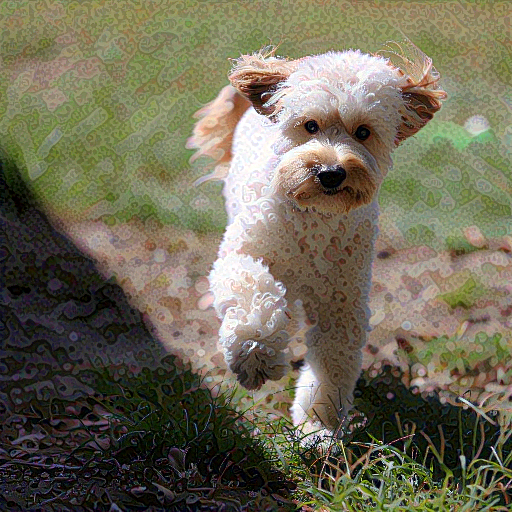

In [8]:
# test out the functions quickly
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

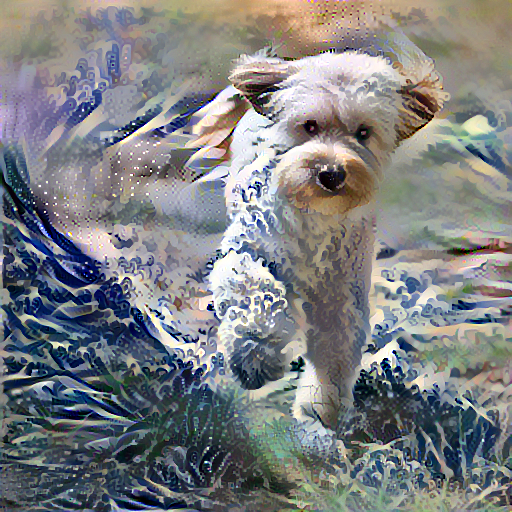

Train step: 500
CPU times: user 1h 17min 43s, sys: 10min 4s, total: 1h 27min 48s
Wall time: 33min 17s


In [9]:
%%time 

epochs = 20
steps_per_epoch = 25

step = 0
img_list = []
for _ in range(epochs):
    for _ in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    im = tensor_to_image(image)
    img_list.append(im)
    display.display(im)
    print("Train step: {}".format(step))


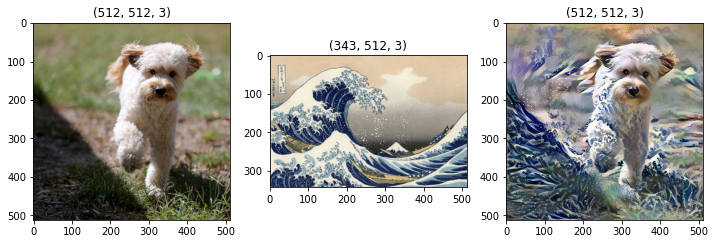

In [12]:
plt.subplot(1, 3, 1)
imshow(content_image)

plt.subplot(1, 3, 2)
imshow(style_image)

plt.subplot(1, 3, 3)
imshow(image.numpy())

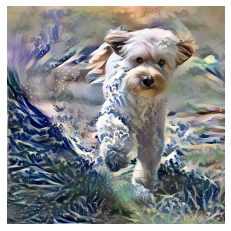

In [10]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")
imgs = [[plt.imshow(img, animated=True)] for img in img_list]
ani = animation.ArtistAnimation(fig, imgs, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Take aways

* Style transfer consists in creating a new image that preserves the "contents" of a target image while also capturing the "style" of a 
reference image.
* "Content" can be captured by the high-level activations of a convnet.
* "Style" can be captured by the internal correlations of the activations of different layers of a convnet.
* Hence deep learning allows style transfer to be formulated as an optimization process using a loss defined with a pre-trained convnet.
* Starting from this basic idea, many variants and refinements are possible!